<a href="https://colab.research.google.com/github/mhmdihsn/UAS-DEEP-LEARNING/blob/main/deeplearning_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD

tf.random.set_seed(42)
np.random.seed(42)

latitude = -6.2
longitude = 106.8
start_date = "2024-01-01"
end_date   = "2024-12-31"

url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,"
    f"relative_humidity_2m_mean,pressure_msl_mean,windspeed_10m_max"
    f"&timezone=Asia%2FJakarta"
)

resp = requests.get(url)
resp.raise_for_status()
data = resp.json()

df = pd.DataFrame({
    'date': data['daily']['time'],
    'temp_mean': data['daily']['temperature_2m_mean'],
    'humidity': data['daily']['relative_humidity_2m_mean'],
    'pressure': data['daily']['pressure_msl_mean'],
    'wind_speed': data['daily']['windspeed_10m_max']
})
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print("Data length:", len(df))
display(df.head())


# FEATURE ENGINEERING

df_fe = df.copy()

# Lag
df_fe['temp_lag1'] = df_fe['temp_mean'].shift(1)
df_fe['temp_lag2'] = df_fe['temp_mean'].shift(2)
df_fe['temp_lag3'] = df_fe['temp_mean'].shift(3)

# Rolling mean & std
df_fe['temp_ma3']  = df_fe['temp_mean'].rolling(window=3).mean()
df_fe['temp_ma7']  = df_fe['temp_mean'].rolling(window=7).mean()
df_fe['temp_std3'] = df_fe['temp_mean'].rolling(window=3).std()
df_fe['temp_std7'] = df_fe['temp_mean'].rolling(window=7).std()

# Changes/diffs
df_fe['temp_change']     = df_fe['temp_mean'].diff()
df_fe['humidity_change'] = df_fe['humidity'].diff()
df_fe['pressure_change'] = df_fe['pressure'].diff()

# Seasonal sin-cos
df_fe['day_sin'] = np.sin(2 * np.pi * df_fe.index.dayofyear / 365)
df_fe['day_cos'] = np.cos(2 * np.pi * df_fe.index.dayofyear / 365)
df_fe['dow_sin'] = np.sin(2 * np.pi * df_fe.index.dayofweek / 7)
df_fe['dow_cos'] = np.cos(2 * np.pi * df_fe.index.dayofweek / 7)

df_fe.dropna(inplace=True)

print("Data FE length:", len(df_fe))
display(df_fe.head())


# FEATURE
features = [
    'temp_mean', 'humidity', 'pressure', 'wind_speed',
    'temp_lag1', 'temp_lag2', 'temp_lag3',
    'temp_ma3', 'temp_ma7', 'temp_std3', 'temp_std7',
    'temp_change', 'humidity_change', 'pressure_change',
    'day_sin', 'day_cos', 'dow_sin', 'dow_cos'
]

X_all = df_fe[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_all)

print("Scaling selesai. Contoh baris pertama:", X_scaled[0])


# DATASET

def create_dataset(dataset, look_back=5):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back, 0])  # target kolom 0 = temp_mean
    return np.array(X), np.array(y)

look_back = 5
X, y = create_dataset(X_scaled, look_back)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

# 5) UTIL: INVERSE SCALE TARGET ke Celsius (SEPERTI NOTEBOOK ANDA)

def inverse_scale_targets(scaled_targets, ref_row, scaler):
    n = len(scaled_targets)
    ref = np.tile(ref_row, (n, 1))      # (n, n_features)
    ref[:, 0] = scaled_targets          # isi kolom 0 dgn target scaled
    inv = scaler.inverse_transform(ref)
    return inv[:, 0]                    # kolom temp_mean asli (C)

ref_row = X_scaled[0]

# =========================
# 6) FUNGSI BUILD MODEL & TRAIN/EVAL
# =========================
def build_model(input_shape, activation_variant=None):
    """
    Baseline Anda: LSTM(64) -> Dense(1)
    Untuk eksperimen activation: tambahkan Dense hidden dgn aktivasi ReLU/Tanh/LeakyReLU
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))

    if activation_variant is None:
        # baseline
        model.add(Dense(1))
    elif activation_variant == "relu":
        model.add(Dense(32, activation="relu"))
        model.add(Dense(1))
    elif activation_variant == "tanh":
        model.add(Dense(32, activation="tanh"))
        model.add(Dense(1))
    elif activation_variant == "leaky_relu":
        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(1))
    else:
        raise ValueError("activation_variant tidak dikenali")

    return model

def train_and_evaluate(exp_name, optimizer, epochs=50, batch_size=16, activation_variant=None):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape, activation_variant=activation_variant)
    model.compile(optimizer=optimizer, loss="mse")

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )

    y_pred = model.predict(X_test, verbose=0).reshape(-1)

    # inverse ke Celsius
    y_test_c = inverse_scale_targets(y_test, ref_row, scaler)
    y_pred_c = inverse_scale_targets(y_pred, ref_row, scaler)

    mse  = mean_squared_error(y_test_c, y_pred_c)
    mae  = mean_absolute_error(y_test_c, y_pred_c)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test_c, y_pred_c)

    metrics = {
        "Eksperimen": exp_name,
        "MSE(C^2)": mse,
        "MAE(C)": mae,
        "RMSE(C)": rmse,
        "R2": r2,
        "epochs": epochs,
        "batch_size": batch_size
    }

    return history, metrics

def plot_loss(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss (scaled)")
    plt.legend()
    plt.show()


Data length: 366


,temp_mean,humidity,pressure,wind_speed
date,,,,
2024-01-01,26.9,87,1009.9,10.9
2024-01-02,27.5,84,1009.0,10.2
2024-01-03,25.7,92,1009.6,8.1
2024-01-04,25.3,92,1010.3,14.1
2024-01-05,26.7,84,1010.4,11.4


Data FE length: 360


,temp_mean,humidity,pressure,wind_speed,temp_lag1,temp_lag2,temp_lag3,temp_ma3,temp_ma7,temp_std3,temp_std7,temp_change,humidity_change,pressure_change,day_sin,day_cos,dow_sin,dow_cos
date,,,,,,,,,,,,,,,,,,
2024-01-07,25.9,90,1010.6,11.6,26.7,26.7,25.3,26.433333,26.385714,0.461880,0.773366,-0.8,4.0,0.6,0.120208,0.992749,-0.781831,0.623490
2024-01-08,26.4,89,1010.4,9.8,25.9,26.7,26.7,26.333333,26.314286,0.404145,0.740335,0.5,-1.0,-0.2,0.137279,0.990532,0.000000,1.000000
2024-01-09,27.3,84,1009.1,8.9,26.4,25.9,26.7,26.533333,26.285714,0.709460,0.689030,0.9,-5.0,-1.3,0.154309,0.988023,0.781831,0.623490
2024-01-10,26.9,87,1008.8,10.9,27.3,26.4,25.9,26.866667,26.457143,0.450925,0.667975,-0.4,3.0,-0.3,0.171293,0.985220,0.974928,-0.222521
2024-01-11,26.9,86,1009.3,13.4,26.9,27.3,26.4,27.033333,26.685714,0.230940,0.441318,0.0,-1.0,0.5,0.188227,0.982126,0.433884,-0.900969


Scaling selesai. Contoh baris pertama: [0.17021277 0.88571429 0.60869565 0.33009709 0.34042553 0.34042553
 0.04255319 0.1637931  0.08715596 0.24854791 0.45775825 0.2244898
 0.65517241 0.71428571 0.56010458 0.99637429 0.09903113 0.80193774]
Shapes:
X_train: (284, 5, 18) y_train: (284,)
X_test : (71, 5, 18) y_test : (71,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,Eksperimen,MSE(C^2),MAE(C),RMSE(C),R2,epochs,batch_size
1,OPT_ADAM_default,0.525519,0.608713,0.724927,0.491313,50,16
0,OPT_SGD_lr0.01,0.850859,0.734514,0.922420,0.176393,50,16


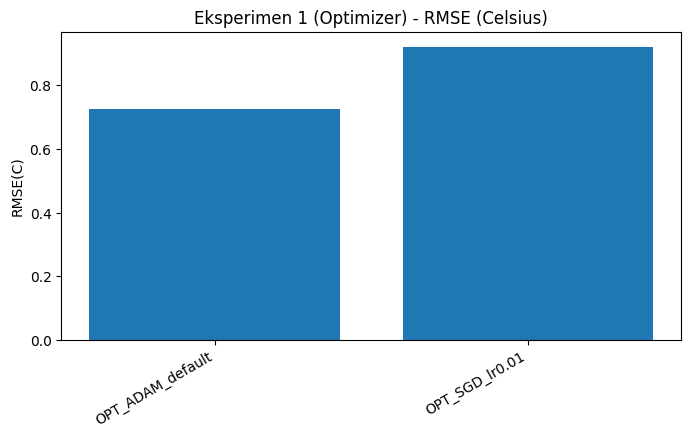

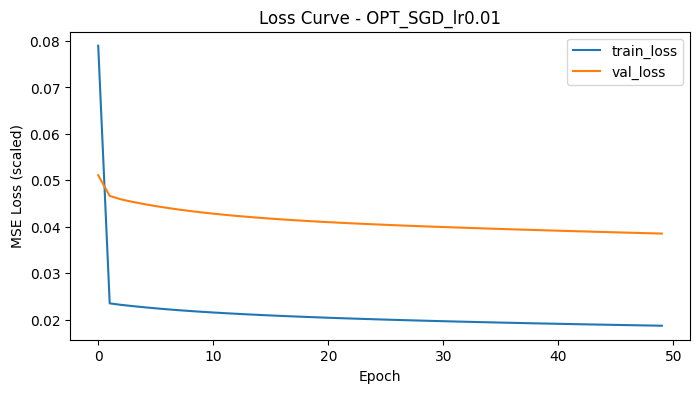

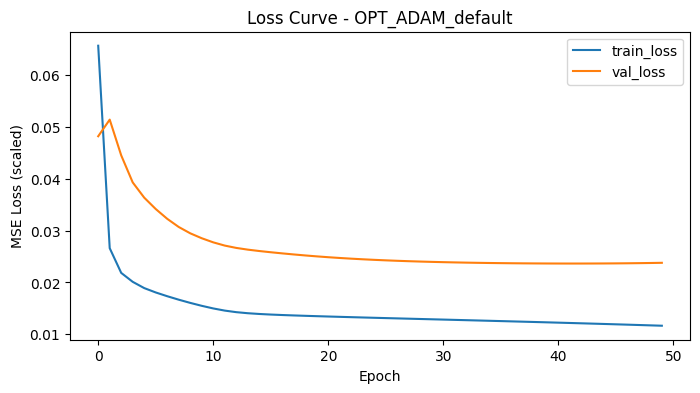

In [ ]:
results_opt = []
hist_opt = {}

h, m = train_and_evaluate(
    exp_name="OPT_SGD_lr0.01",
    optimizer=SGD(learning_rate=0.01),
    epochs=50, batch_size=16,
    activation_variant=None
)
hist_opt[m["Eksperimen"]] = h
results_opt.append(m)

h, m = train_and_evaluate(
    exp_name="OPT_ADAM_default",
    optimizer=Adam(),  # default lr
    epochs=50, batch_size=16,
    activation_variant=None
)
hist_opt[m["Eksperimen"]] = h
results_opt.append(m)

df_opt = pd.DataFrame(results_opt).sort_values(by="RMSE(C)")
display(df_opt)

# Grafik perbandingan RMSE
plt.figure(figsize=(8,4))
plt.bar(df_opt["Eksperimen"], df_opt["RMSE(C)"])
plt.title("Eksperimen 1 (Optimizer) - RMSE (Celsius)")
plt.ylabel("RMSE(C)")
plt.xticks(rotation=30, ha="right")
plt.show()

# Kurva loss
for name, h in hist_opt.items():
    plot_loss(h, f"Loss Curve - {name}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negat

,Eksperimen,MSE(C^2),MAE(C),RMSE(C),R2,epochs,batch_size
1,ACT_Tanh(Dense32)+Adam,0.477440,0.573763,0.690970,0.537852,50,16
0,ACT_ReLU(Dense32)+Adam,0.612798,0.641060,0.782814,0.406829,50,16
2,ACT_LeakyReLU(Dense32)+Adam,0.615839,0.648853,0.784754,0.403886,50,16


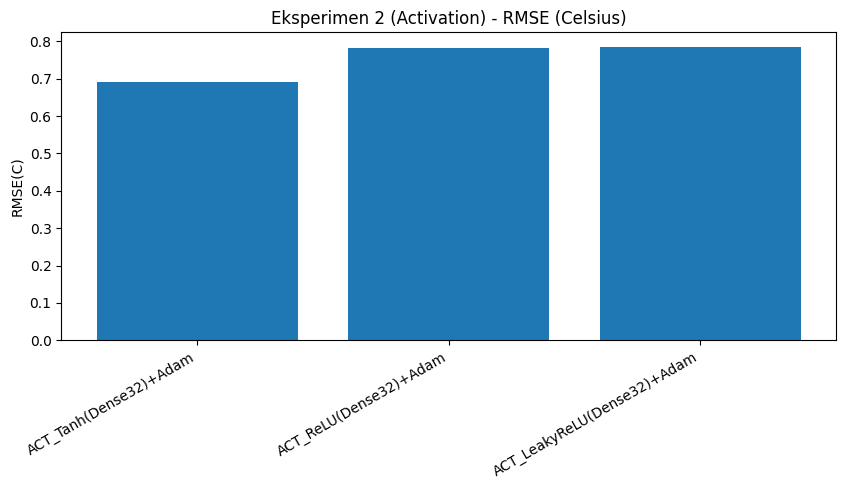

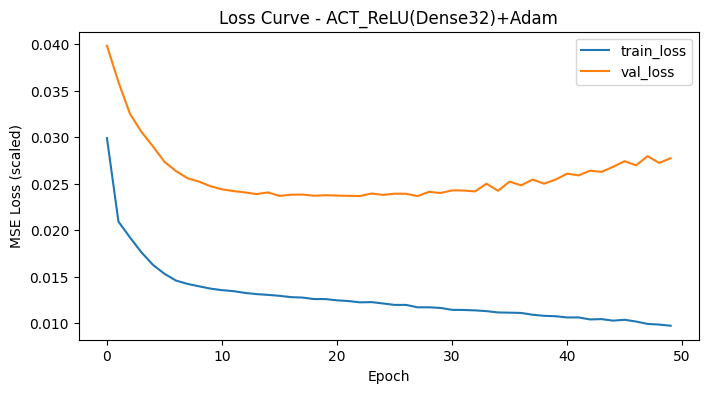

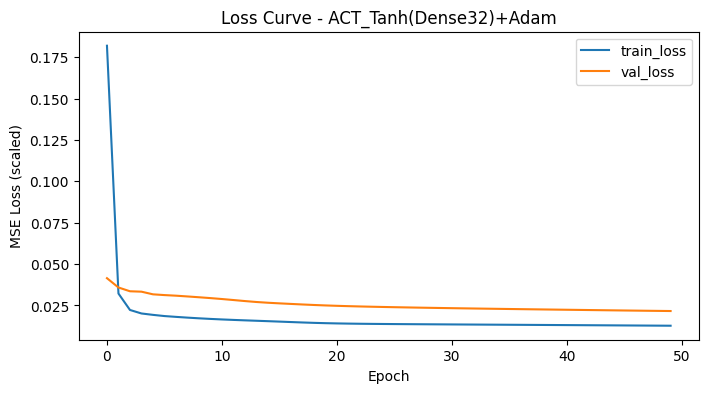

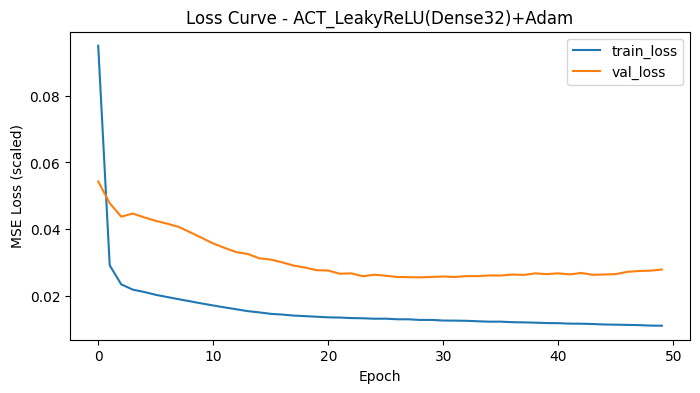

In [ ]:
results_act = []
hist_act = {}

h, m = train_and_evaluate(
    exp_name="ACT_ReLU(Dense32)+Adam",
    optimizer=Adam(),
    epochs=50, batch_size=16,
    activation_variant="relu"
)
hist_act[m["Eksperimen"]] = h
results_act.append(m)

h, m = train_and_evaluate(
    exp_name="ACT_Tanh(Dense32)+Adam",
    optimizer=Adam(),
    epochs=50, batch_size=16,
    activation_variant="tanh"
)
hist_act[m["Eksperimen"]] = h
results_act.append(m)

h, m = train_and_evaluate(
    exp_name="ACT_LeakyReLU(Dense32)+Adam",
    optimizer=Adam(),
    epochs=50, batch_size=16,
    activation_variant="leaky_relu"
)
hist_act[m["Eksperimen"]] = h
results_act.append(m)

df_act = pd.DataFrame(results_act).sort_values(by="RMSE(C)")
display(df_act)

# Grafik perbandingan RMSE
plt.figure(figsize=(10,4))
plt.bar(df_act["Eksperimen"], df_act["RMSE(C)"])
plt.title("Eksperimen 2 (Activation) - RMSE (Celsius)")
plt.ylabel("RMSE(C)")
plt.xticks(rotation=30, ha="right")
plt.show()

# Kurva loss
for name, h in hist_act.items():
    plot_loss(h, f"Loss Curve - {name}")


,Eksperimen,MSE(C^2),MAE(C),RMSE(C),R2,epochs,batch_size,Kelompok
2,ACT_Tanh(Dense32)+Adam,0.477440,0.573763,0.690970,0.537852,50,16,Activation
0,OPT_ADAM_default,0.525519,0.608713,0.724927,0.491313,50,16,Optimizer
3,ACT_ReLU(Dense32)+Adam,0.612798,0.641060,0.782814,0.406829,50,16,Activation
4,ACT_LeakyReLU(Dense32)+Adam,0.615839,0.648853,0.784754,0.403886,50,16,Activation
1,OPT_SGD_lr0.01,0.850859,0.734514,0.922420,0.176393,50,16,Optimizer


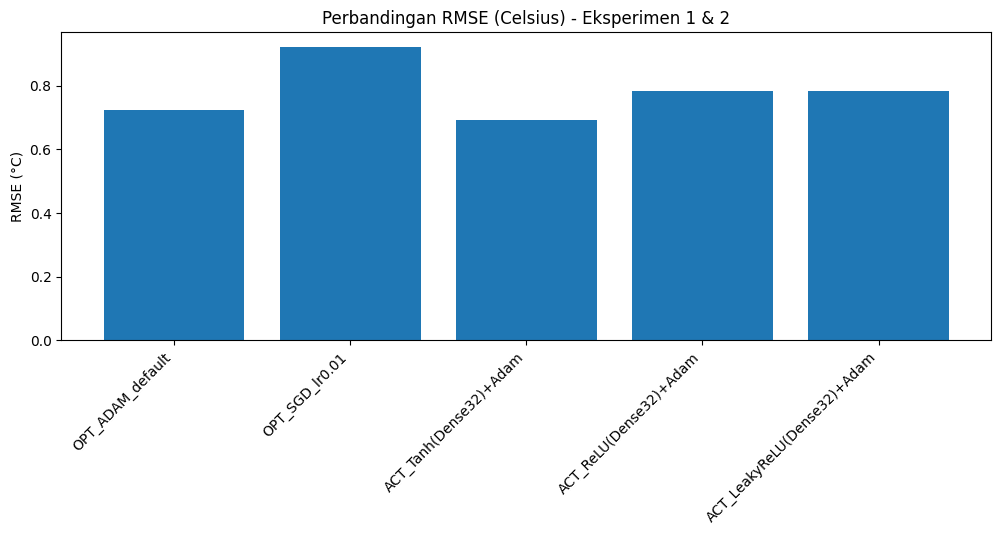

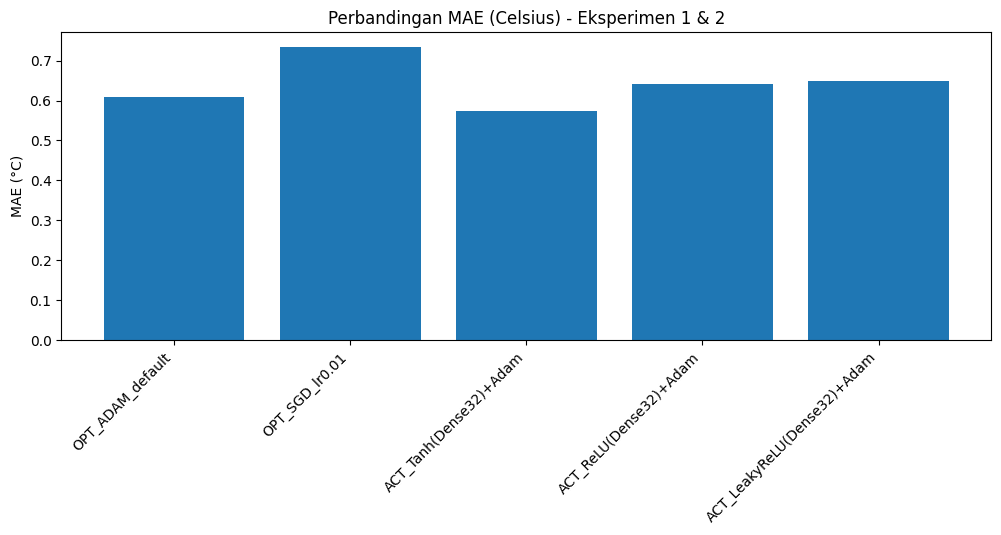

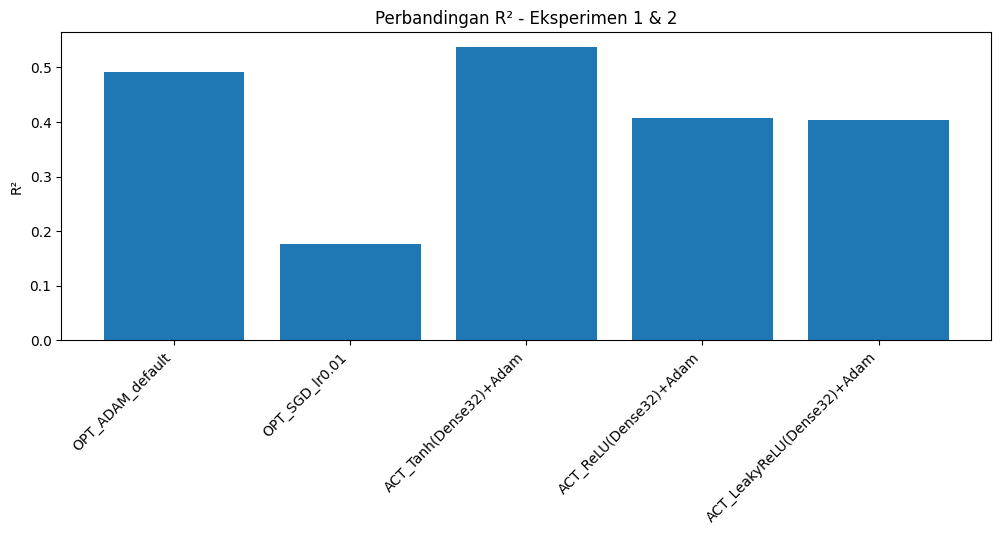

In [ ]:
import matplotlib.pyplot as plt

# Gabungkan untuk ringkasan
df_all = pd.concat([df_opt.assign(Kelompok="Optimizer"),
                    df_act.assign(Kelompok="Activation")], ignore_index=True)

display(df_all.sort_values("RMSE(C)"))

# Bar RMSE
plt.figure(figsize=(12,4))
plt.bar(df_all["Eksperimen"], df_all["RMSE(C)"])
plt.xticks(rotation=45, ha="right")
plt.title("Perbandingan RMSE (Celsius) - Eksperimen 1 & 2")
plt.ylabel("RMSE (°C)")
plt.show()

# Bar MAE
plt.figure(figsize=(12,4))
plt.bar(df_all["Eksperimen"], df_all["MAE(C)"])
plt.xticks(rotation=45, ha="right")
plt.title("Perbandingan MAE (Celsius) - Eksperimen 1 & 2")
plt.ylabel("MAE (°C)")
plt.show()

# Optional: Bar R2
plt.figure(figsize=(12,4))
plt.bar(df_all["Eksperimen"], df_all["R2"])
plt.xticks(rotation=45, ha="right")
plt.title("Perbandingan R² - Eksperimen 1 & 2")
plt.ylabel("R²")
plt.show()


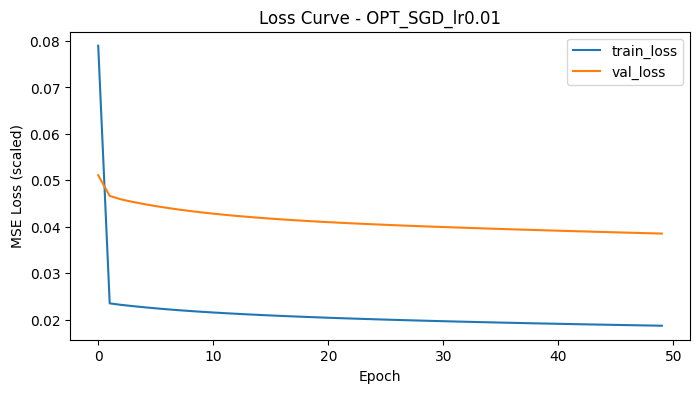

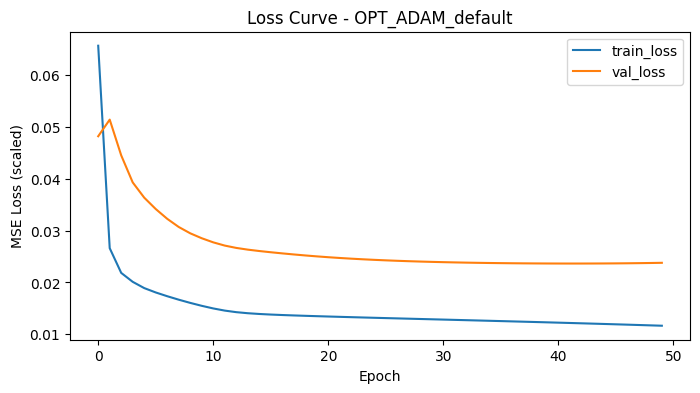

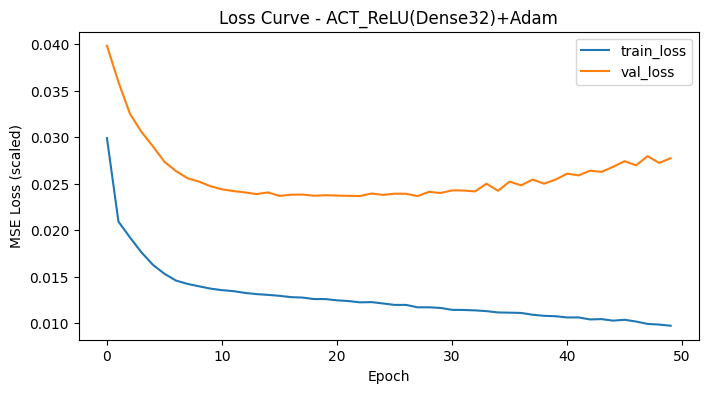

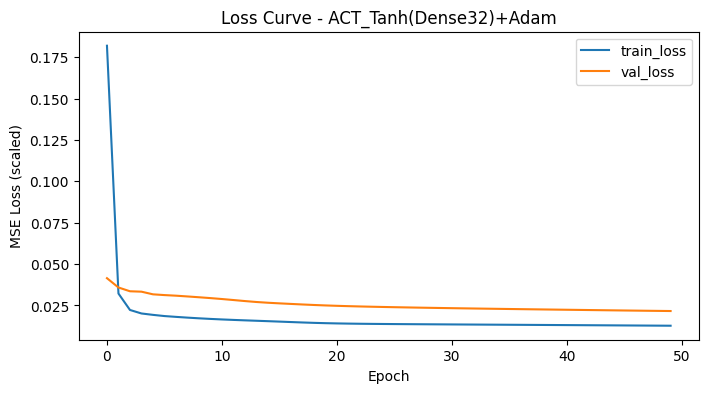

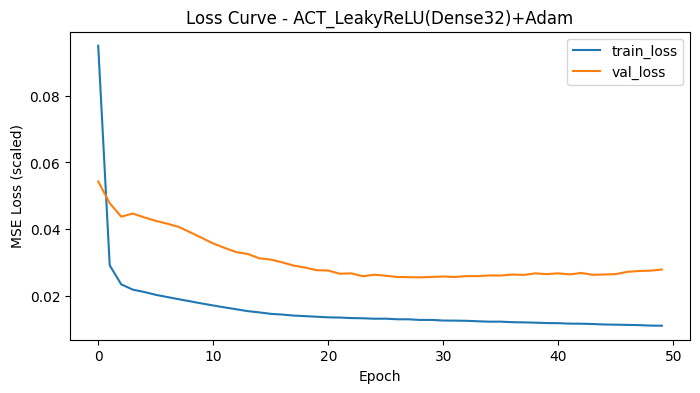

In [ ]:
def plot_loss(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss (scaled)")
    plt.legend()
    plt.show()

# Eksperimen 1
for name, h in hist_opt.items():
    plot_loss(h, f"Loss Curve - {name}")

# Eksperimen 2
for name, h in hist_act.items():
    plot_loss(h, f"Loss Curve - {name}")
